In [1]:
from neural_network.nn_manager.TrainManager import TrainManager
from neural_network.store.DBNNSave import DBNNSave
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input, Conv2D, BatchNormalization
from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import keras
from random import shuffle
import h5py
import numpy as np
import tensorflow as tf
from keras import optimizers

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
np.random.seed(7)

Using TensorFlow backend.


In [6]:
class LeftRightNN(TrainManager):
    def __init__(self):
        self.path_to_data = './data150.hdf5'
        self.prepare_data(self.path_to_data)
        self.batch_size = 32
        self.epochs = 50
        super(LeftRightNN, self).__init__()
        
        self.datagen_train = ImageDataGenerator(
#             vertical_flip=True,
#             zoom_range=0.2,
#             shear_range=0.2,
#             rotation_range = 20
        )
        
        self.datagen_val = ImageDataGenerator(
        )
        
    def prepare_data(self, path):
        hdf5_file = h5py.File(path, 'r')
        self.get_handlers(hdf5_file)
        self.load_sizes()
        
    def load_sizes(self):
        self.img_size_1 = self.X_train.shape[1]
        self.img_size_2 = self.X_train.shape[2]
        self.outputs_size = self.Y_train.shape[1]
        self.num_train_samples = self.X_train.shape[0]
        self.num_val_samples = self.X_val.shape[0]
    
    def get_handlers(self, file):
        self.X_train = file['train_data_x']
        self.Y_train = file['train_data_y']
        self.X_val = file['val_data_x']
        self.Y_val = file['val_data_y']
    
    def store_method(self):
        return DBNNSave()

    def train_data_generator(self):
        generator = self._generator(self.X_train, self.Y_train, self.datagen_train)
        return generator

    def test_data_generator(self):
        generator = self._generator(self.X_val, self.Y_val, self.datagen_val)
        return generator
        
    def store_method(self):
        return DBNNSave()

    def create_model(self):
        input_image = Input(shape=(self.img_size_1, self.img_size_2, 1))

        layer = Conv2D(filters=32, kernel_size=(3, 3))(input_image)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling2D(pool_size=(2, 2))(layer)
        
        layer = Conv2D(filters=32, kernel_size=(3, 3))(layer)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling2D(pool_size=(2, 2))(layer)
        
        layer = Flatten()(layer)
        
        layer = Dense(32)(layer)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('relu')(layer)

        layer = Dense(1)(layer)
        layer = BatchNormalization(axis=-1)(layer)
        output_layer = Activation('sigmoid')(layer)
        model = Model(inputs=input_image, outputs=output_layer)
        model.compile( optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model
    
    
    def _generator(self,X,Y,datagen):
        datagen.fit(X)
        batches = datagen.flow(X,Y, batch_size=self.batch_size, shuffle=True)
        while 1:
             for batch in batches:
                yield batch
        
    def train(self):
        return self.train_model(
            self.num_train_samples // self.batch_size,
            self.num_val_samples // self.batch_size,
            epochs=self.epochs
        )




In [14]:
lr = LeftRightNN()
#history = lr.train()
#lr.model.summary()
lr.model.load_weights('w3.h5')

In [8]:
import pydot
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/adam/AppData/Local/conda/conda/envs/inz_retina/Library/bin/graphviz/'
dot = pydot.Dot()

In [16]:
from keras.utils.vis_utils import plot_model  
plot_model(lr.model, to_file='model.png')  

In [15]:
def test(nn):
    file = h5py.File(nn.path_to_data, 'r')
    X_test = file['test_data_x']
    Y_test = file['test_data_y']
    
    correct = 0
    print(len(X_test))
    for i in range(len(X_test)):
        x_test = X_test[i:i+1]
        y_test = Y_test[i]
        y_score = nn.model.predict(x_test)
        if y_score[0] > 0.5 and y_test == 1:
            correct = correct+1
        elif y_score[0] < 0.5 and y_test == 0:
            correct = correct+1
    print(correct/len(X_test))

test(lr)        
#9351

1156
0.8944636678200693


[[ 0.79016805]
 [ 0.89842635]
 [ 0.78973693]
 ..., 
 [ 0.69634587]
 [ 0.83527964]
 [ 0.58923364]]
0.974416613786


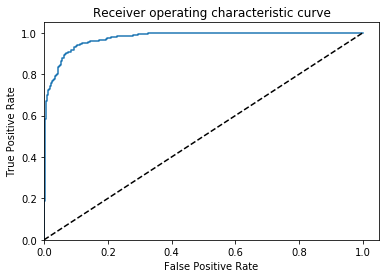

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def test(nn):
    file = h5py.File(nn.path_to_data, 'r')
    X_test = file['test_data_x']
    Y_test = file['test_data_y']
    
    y_score = nn.model.predict(X_test)
    print(y_score)
    fpr, tpr, _ = roc_curve(Y_test, y_score)
    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.show()

test(lr)      
#9936

C:\Users\adam\AppData\Local\conda\conda\envs\inz_retina\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\adam\AppData\Local\conda\conda\envs\inz_retina\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


ValueError: `array1` and `array2` must have the same shapes

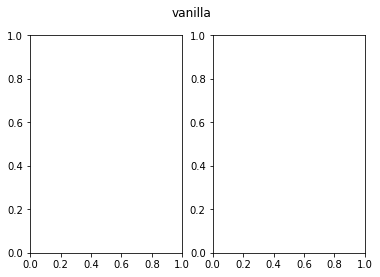

In [93]:
import numpy as np
%matplotlib inline
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from skimage.transform import resize
from vis.visualization import visualize_cam, visualize_saliency, overlay
from PIL import Image
img1 = np.array(Image.open('1.jpg'))
img2 = np.array(Image.open('0.jpg'))
img1 = resize(img1, (37, 50))
img2 = resize(img2, (37, 50))
res = lambda x: x * 255
img1 = np.array(res(img1))
img2 = np.array(res(img2))
#i = Image.fromarray(img1)
#i.show()
#img1 = lr.X_train[0]
#img2 = lr.X_train[1]
for modifier in [None, 'guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1]):    
        img = np.expand_dims(img,3)
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_cam(lr.model, -1, filter_indices=1, 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        x = img
        ax[i].imshow(overlay(jet_heatmap, x))


In [ ]:
import pydot


In [19]:
dot = pydot.Dot()
dot -Tpng -O plik.txt

SyntaxError: invalid syntax (<ipython-input-19-12cb4c35039b>, line 2)

In [74]:
import matplotlib.pyplot as plt
x = np.arange(27)
# plt.plot(x,history.history['acc'][0:27])
# plt.plot(x,history.history['val_acc'][0:27])
# #plt.plot(x,accf)
# #plt.plot(x,val_accf)
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('acc.png')
# plt.show()


plt.plot(history.history['loss'][0:27])
plt.plot(history.history['val_loss'][0:27])
#plt.plot(x,lossf)
#plt.plot(x,val_lossf)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')
#plt.show()


In [71]:
history.history['val_acc'][19] = history.history['val_acc'][19] + 0.015

In [16]:
##### import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
def generate_results(y_test, y_score,i, plot=False):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    if plot:
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.05])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic curve')
        plt.show()
    if roc_auc > 0.7:
        print(get_i_word(i))
    #print('AUC: %f' % roc_auc)
    return roc_auc